## Setting Up:

In [1]:
import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
import massbalancemachine as mbm
import geopandas as gpd
from shapely.geometry import Polygon, LineString, Point
from scipy.spatial.distance import cdist
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GroupKFold, KFold, train_test_split, GroupShuffleSplit

import cupy as cp
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm

from scripts.helpers import *
from scripts.glamos_preprocess import *
from scripts.plots import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [2]:
seed_all(SEED)
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

In [3]:
# RGI Ids:
# Read rgi ids:
path_rgi = '../../../data/GLAMOS/CH_glacier_ids_long.csv'
rgi_df = pd.read_csv(path_rgi, sep=',')
rgi_df.rename(columns=lambda x: x.strip(), inplace=True)
rgi_df.sort_values(by='short_name', inplace=True)
rgi_df.set_index('short_name', inplace=True)

## All data:

In [4]:
# Switch to oggm datapulling notebook:
df_pmb_topo = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
print('Number of winter and annual samples:', len(df_pmb_topo))
print('Number of annual samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'annual']))
print('Number of winter samples:',
      len(df_pmb_topo[df_pmb_topo.PERIOD == 'winter']))
df_pmb_topo.head(2)

# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']

# take only annual and not winter MB
data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
data = data[data.PERIOD == 'annual']

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)
dataset.data.head(2)

Number of winter and annual samples: 9809
Number of annual samples: 8258
Number of winter samples: 1551


,YEAR,POINT_ID,GLACIER,FROM_DATE,TO_DATE,POINT_LAT,POINT_LON,POINT_ELEVATION,POINT_BALANCE,PERIOD,...,tp_feb,tp_mar,tp_apr,tp_may,tp_jun,tp_jul,tp_aug,tp_sep,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE
0,2006,100,adler,20051017,20061011,46.010637,7.855896,3096.507742,-2.592,annual,...,0.003583,0.003874,0.00389,0.005349,0.007002,0.007252,0.006498,0.008244,2787.508638,-308.999104
1,2006,200,adler,20051017,20061011,46.010052,7.858628,3141.506520,-2.502,annual,...,0.003583,0.003874,0.00389,0.005349,0.007002,0.007252,0.006498,0.008244,2787.508638,-353.997882


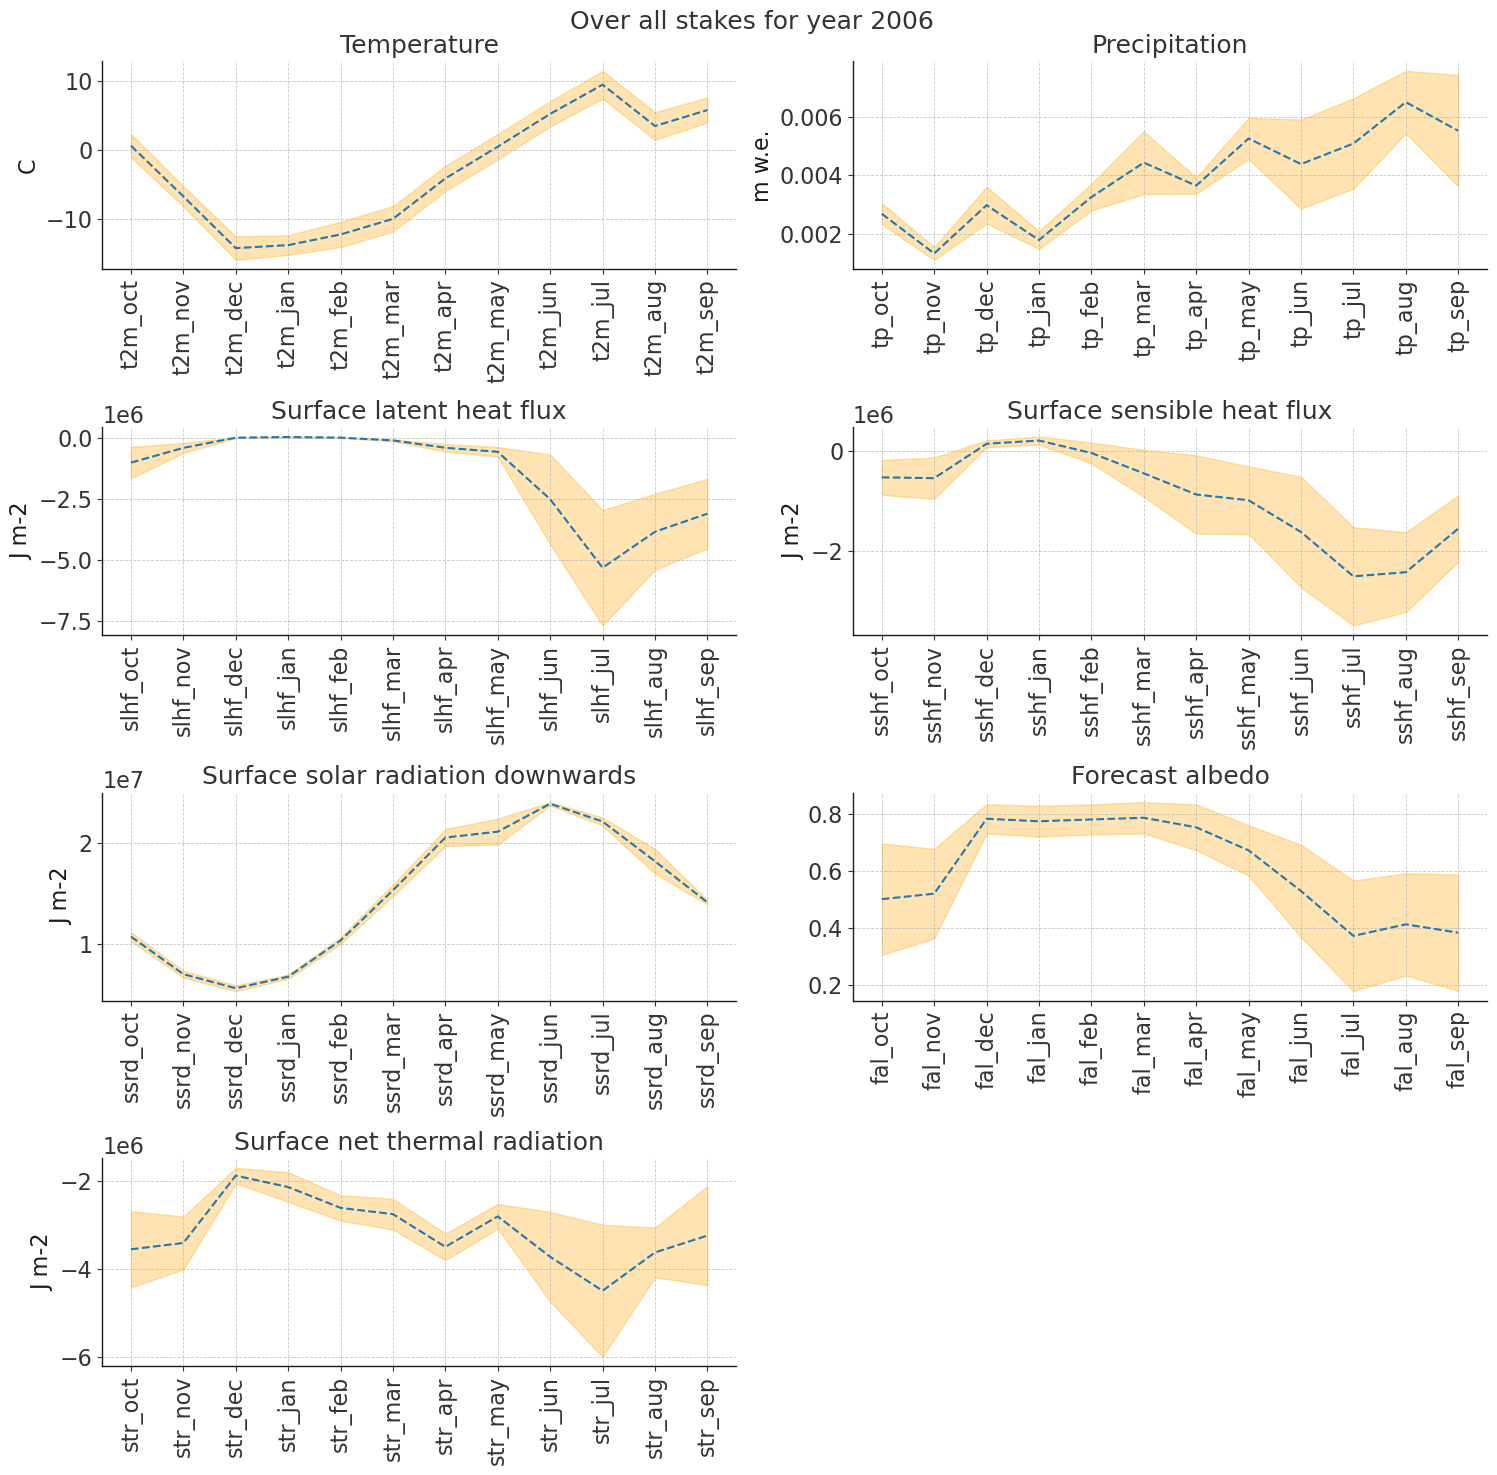

In [5]:
# Plot temperature and precipitation for all stakes:
fig = plt.figure(figsize=(15, 15))
df = dataset.data
year = 2006

for i, var in enumerate(vois_climate):
    temp = df[df.YEAR == year][[col for col in df.columns if var in col]]
    mean = temp.mean().values
    std = temp.std().values
    ax = plt.subplot(4, 2, i + 1)
    ax.fill_between(
        temp.columns,
        mean - std,
        mean + std,
        color="orange",
        alpha=0.3,
    )
    # put x axis at 45 degrees
    ax.set_xticklabels(temp.columns, rotation=90)
    ax.plot(temp.columns, mean, label='Mean Annual Point SMB', linestyle="--")
    ax.set_title(vois_climate_long_name[var])
    ax.set_ylabel(vois_units[var])

plt.suptitle('Over all stakes for year ' + str(year))
plt.tight_layout()

## Test on Silvretta:

Number of winter and annual samples: 1611
Number of annual samples: 1367
Number of winter samples: 244


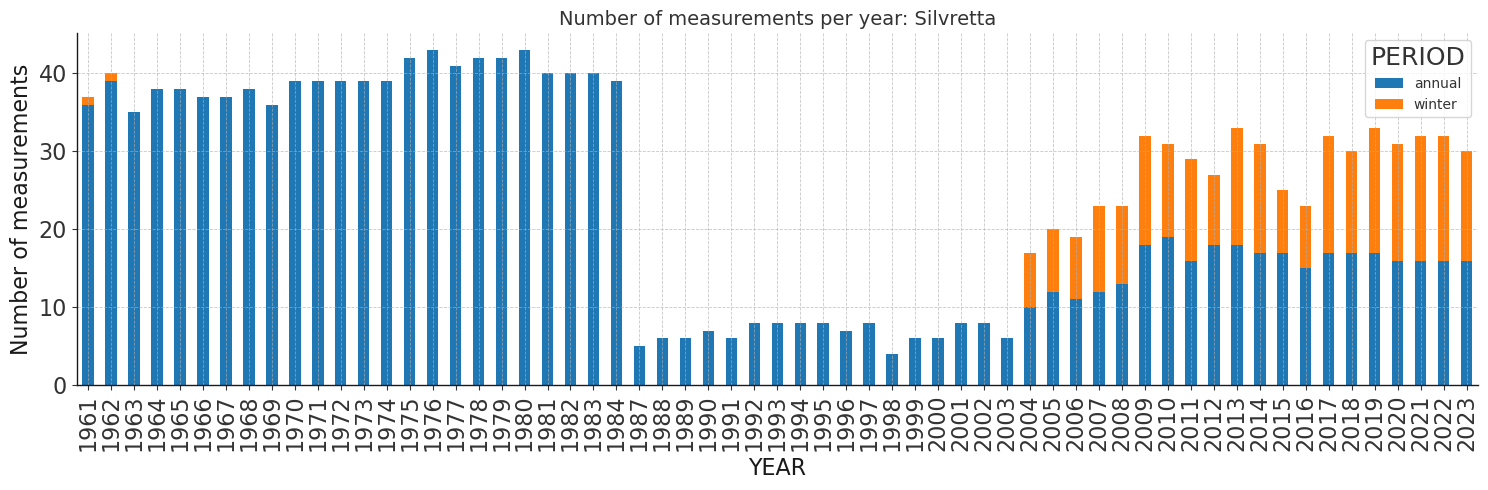

In [6]:
rgi_Silvretta = rgi_df.loc['silvretta']['rgi_id.v6']

data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_Silvretta)]
data = data[data.RGIId == rgi_Silvretta]

print('Number of winter and annual samples:', len(data))
print('Number of annual samples:', len(data[data.PERIOD == 'annual']))
print('Number of winter samples:', len(data[data.PERIOD == 'winter']))

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000

# Plot number of measurements per year
# Number of measurements per glacier per year:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
num_gl_yr = data.groupby(['YEAR', 'PERIOD']).size().unstack().reset_index()
num_gl_yr.plot(x='YEAR', kind='bar', stacked=True, ax=ax, title='Silvretta')
ax.set_ylabel('Number of measurements')
ax.set_title('Number of measurements per year: Silvretta', fontsize=14)
plt.tight_layout()

In [7]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']
meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS", "PERIOD"]

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)


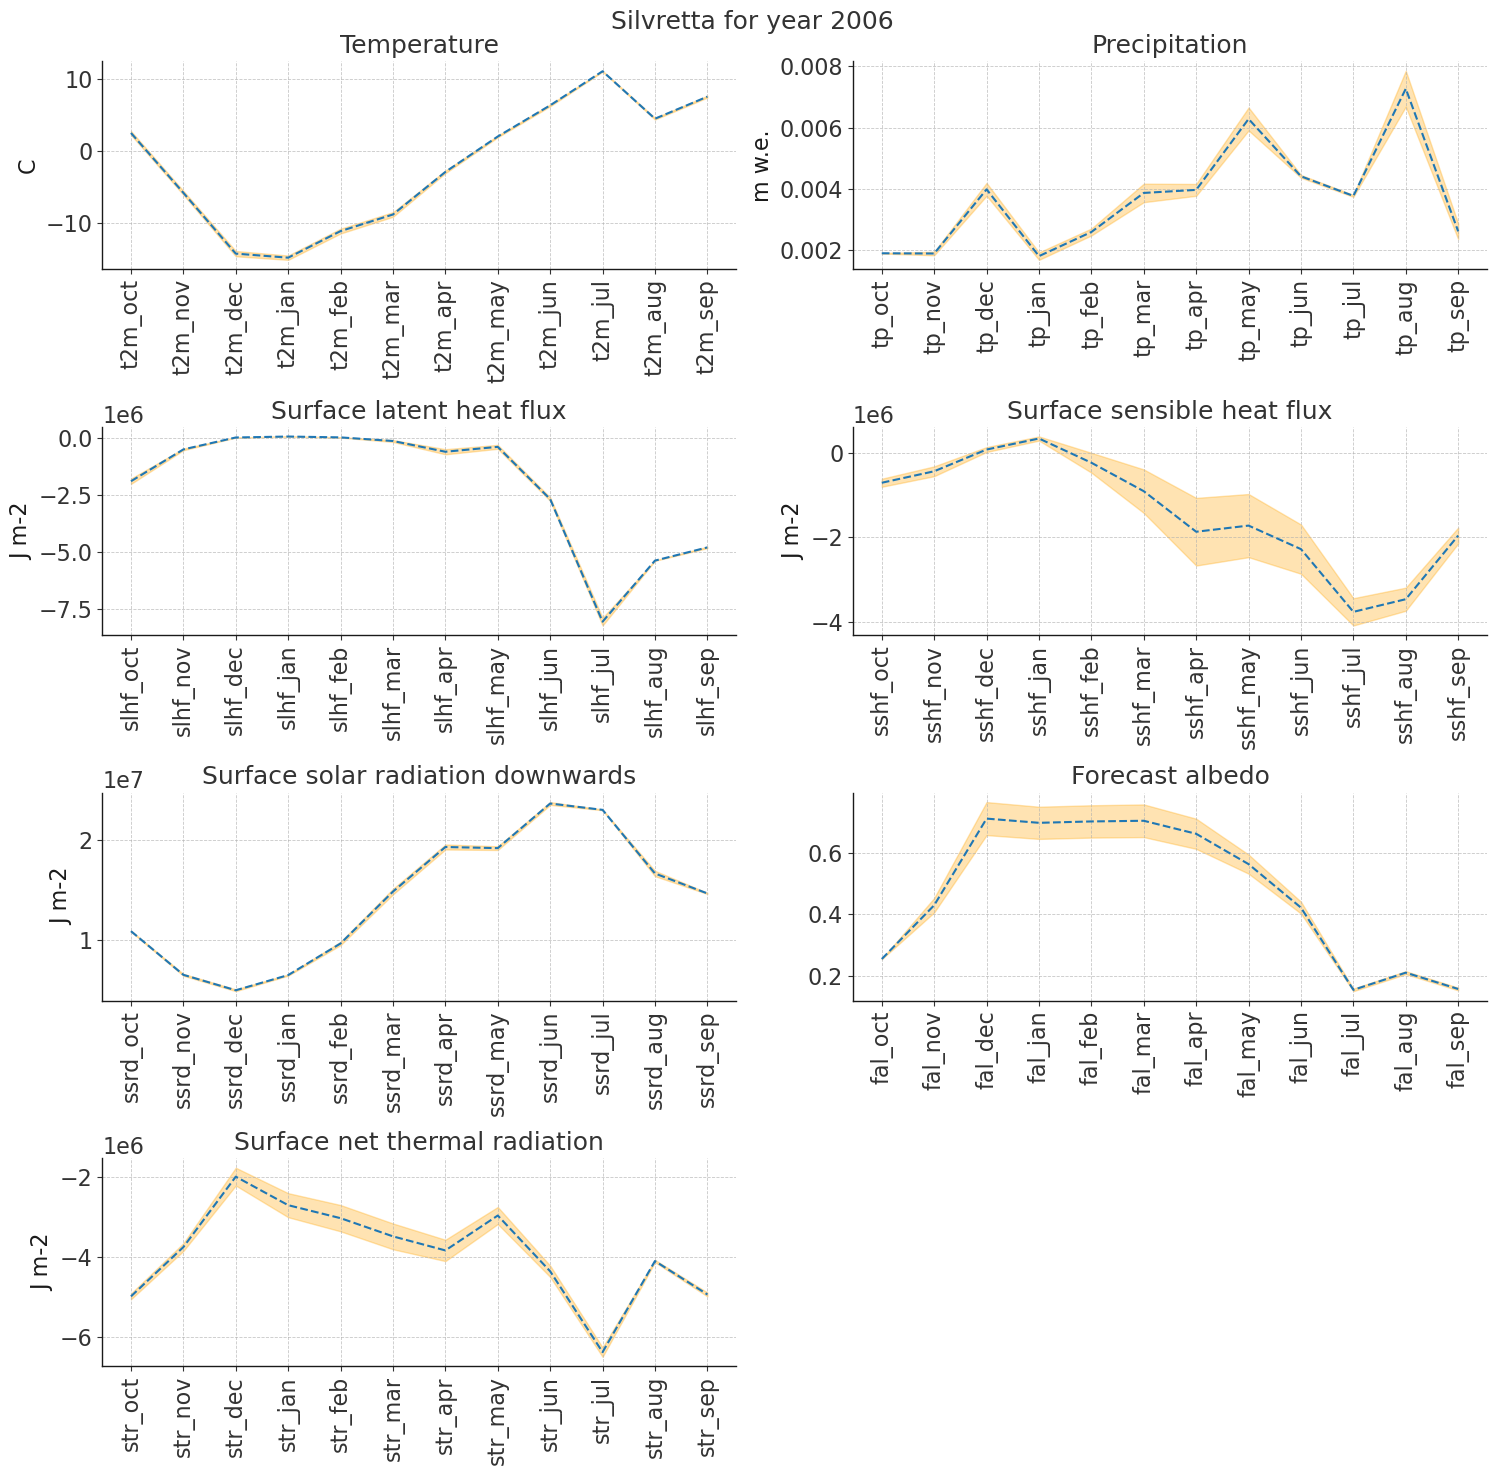

In [8]:
# Plot temperature and precipitation for all stakes:
fig = plt.figure(figsize=(15, 15))
df = dataset.data
year = 2006

for i, var in enumerate(vois_climate):
    temp = df[df.YEAR == year][[col for col in df.columns if var in col]]
    mean = temp.mean().values
    std = temp.std().values
    ax = plt.subplot(4, 2, i + 1)
    ax.fill_between(
        temp.columns,
        mean - std,
        mean + std,
        color="orange",
        alpha=0.3,
    )
    # put x axis at 45 degrees
    ax.set_xticklabels(temp.columns, rotation=90)
    ax.plot(temp.columns, mean, label='Mean Annual Point SMB', linestyle="--")
    ax.set_title(vois_climate_long_name[var])
    ax.set_ylabel(vois_units[var])

plt.suptitle('Silvretta for year ' + str(year))
plt.tight_layout()

In [9]:
# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(meta_data_columns=meta_data_columns,
                           vois_climate=vois_climate,
                           vois_topographical=voi_topographical)

# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset.data,
                            random_seed=SEED,
                            meta_data_columns=meta_data_columns)

### Splits:

Train years: [1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1972 1973 1974 1975
 1976 1977 1979 1980 1981 1982 1983 1984 1989 1990 1991 1992 1993 1996
 1997 1998 1999 2001 2002 2005 2009 2010 2011 2012 2013 2014 2015 2017
 2018 2019 2020 2021 2022 2023]
Test years: [1971 1978 1987 1988 1994 1995 2000 2003 2004 2006 2007 2008 2016]


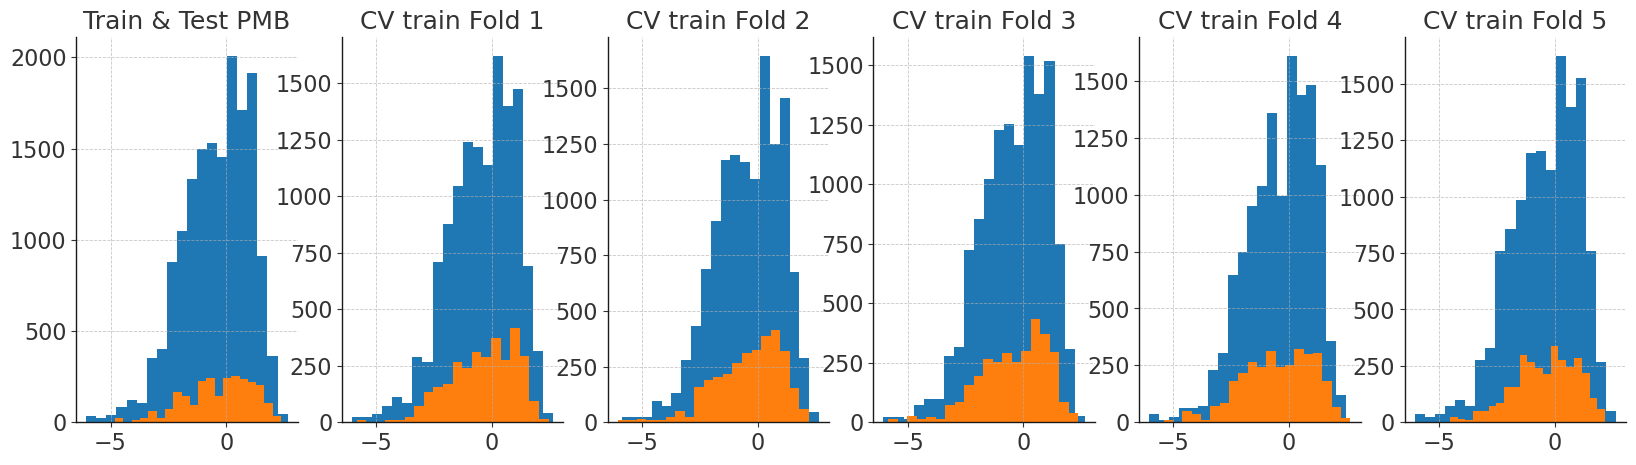

In [10]:
TYPE_SPLIT = 'year'

if TYPE_SPLIT == 'year':
    # Split into training and test years with train_test_split
    train_years, test_years = train_test_split(dataset.data.YEAR.unique(),
                                               test_size=0.2,
                                               random_state=SEED)

    train_indices = dataset.data[dataset.data.YEAR.isin(train_years)].index
    test_indices = dataset.data[dataset.data.YEAR.isin(test_years)].index

    dataloader.set_custom_train_test_indices(train_indices, test_indices)

else:
    # Randomly (though does not separate meas ID)
    train_itr, test_itr = dataloader.set_train_test_split(test_size=0.2,
                                                          shuffle=True)

    train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = dataset.data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = dataset.data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the CV splits based on the training dataset. The default value for the number of splits is 5.
splits = dataloader.get_cv_split(n_splits=5, type_fold='group-meas-id')
test_meas_id = df_X_test['ID'].unique()

# Years in training and test set
train_years = df_X_train.YEAR.unique()
test_years = df_X_test.YEAR.unique()
print('Train years:', train_years)
print('Test years:', test_years)

# Plot splits
visualiseSplits(y_test, y_train, splits)

In [11]:
%%time
# Grid search
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = SEED

# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(
    meta_data_columns=meta_data_columns, **param_init)
custom_xgboost.randomsearch(
    parameters=parameters,
    n_iter=20,
    splits=splits,
    features=df_X_train,
    targets=y_train,
    num_jobs=-1,
    random_seed=SEED,
)

best_params = params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect'

/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:04:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']

features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


### Predict with best model:

features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']
features: ['ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf', 'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp']


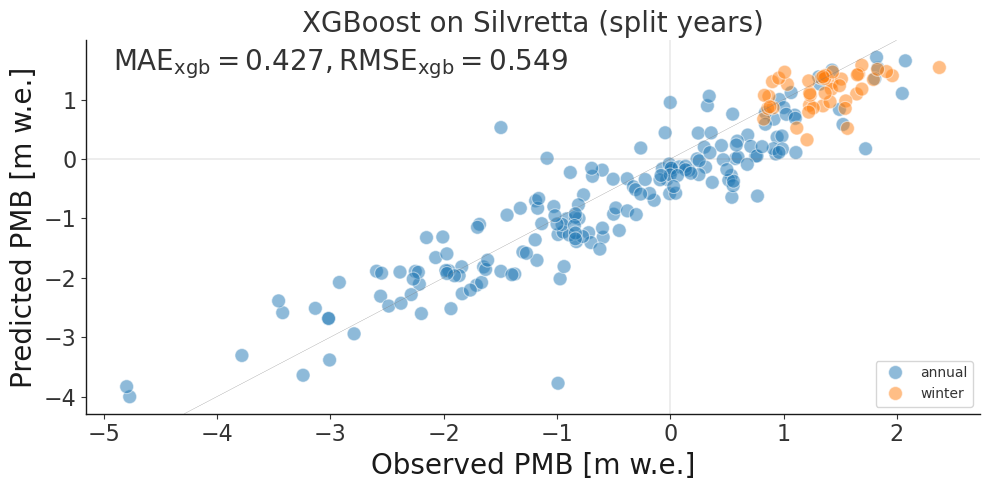

In [12]:
# Set to CPU for predictions:
xgb = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = xgb._create_features_metadata(
    df_X_test, meta_data_columns)
y_pred = xgb.predict(features_test)

# Make predictions aggr to meas ID:
y_pred_agg = xgb.aggrPredict(metadata_test, meta_data_columns, features_test)

# Calculate scores
score = xgb.score(df_X_test, y_test)  # negative
mse, rmse, mae = xgb.evalMetrics(metadata_test, y_pred, y_test)

# Aggregate predictions to annual or winter:
df_pred = df_X_test.copy()
df_pred['target'] = y_test
grouped_ids = df_pred.groupby('ID').agg({'target': 'mean'})
grouped_ids['pred'] = y_pred_agg
grouped_ids['PERIOD'] = df_X_test.groupby('ID')['PERIOD'].first()

predVSTruth(grouped_ids, mae, rmse, title='XGBoost on Silvretta (split years)')


## Test on Gries:

Number of winter and annual samples: 1943
Number of annual samples: 1646
Number of winter samples: 297


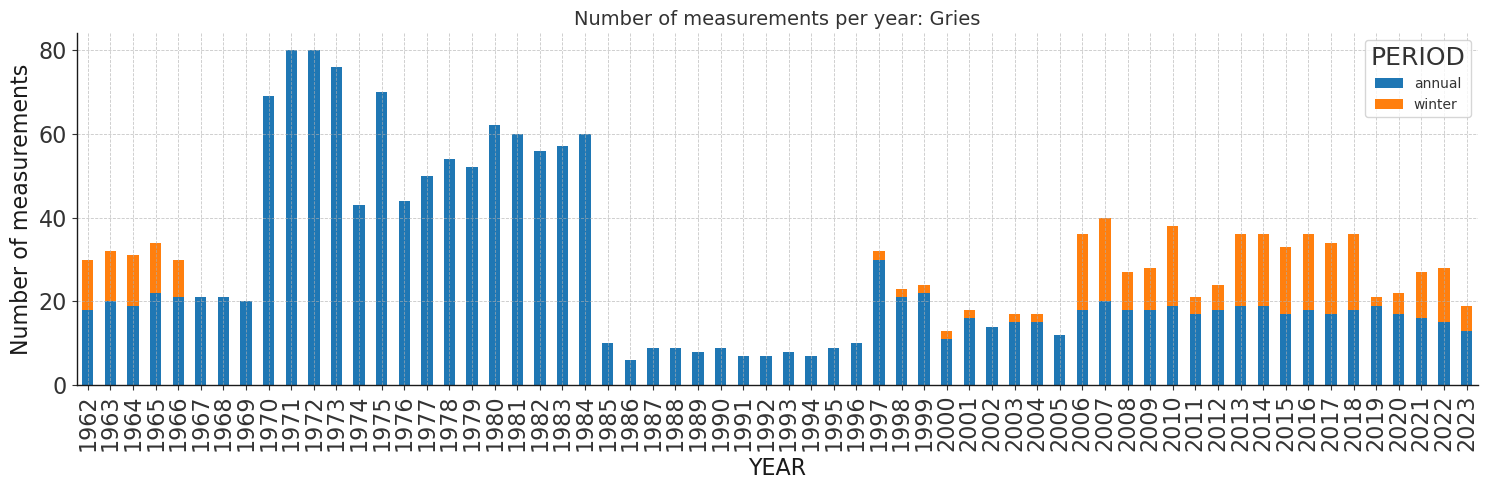

In [13]:
rgi_Gries = rgi_df.loc['gries']['rgi_id.v6']

data = pd.read_csv(path_PMB_GLAMOS_csv + 'CH_wgms_dataset.csv')
# data = data[(data.PERIOD == 'annual') & (data.RGIId == rgi_Gries)]
data = data[data.RGIId == rgi_Gries]

print('Number of winter and annual samples:', len(data))
print('Number of annual samples:', len(data[data.PERIOD == 'annual']))
print('Number of winter samples:', len(data[data.PERIOD == 'winter']))

# change mm w.e. to m w.e.
data['POINT_BALANCE'] = data['POINT_BALANCE'] / 1000

# Plot number of measurements per year
# Number of measurements per glacier per year:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
num_gl_yr = data.groupby(['YEAR', 'PERIOD']).size().unstack().reset_index()
num_gl_yr.plot(x='YEAR', kind='bar', stacked=True, ax=ax, title='Gries')
ax.set_ylabel('Number of measurements')
ax.set_title('Number of measurements per year: Gries', fontsize=14)
plt.tight_layout()

In [14]:
# Specify the short names of the climate variables available in the dataset
vois_climate = ['t2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str']
# voi_topographical = ['aspect', 'slope', 'dis_from_border', 'topo']
voi_topographical = ['aspect', 'slope']
meta_data_columns = ["RGIId", "POINT_ID", "ID", "N_MONTHS", "MONTHS", "PERIOD"]

# Provide the column name for the column that has the RGI IDs for each of the stakes
dataset = mbm.Dataset(data=data,
                      region_name='CH',
                      data_path=path_PMB_GLAMOS_csv)

# Add climate data:
# Specify the files of the climate data, that will be matched with the coordinates of the stake data
era5_climate_data = path_ERA5_raw + 'era5_monthly_averaged_data.nc'
geopotential_data = path_ERA5_raw + 'era5_geopotential_pressure.nc'

# Match the climate features, from the ERA5Land netCDF file, for each of the stake measurement dataset
dataset.get_climate_features(climate_data=era5_climate_data,
                             geopotential_data=geopotential_data,
                             change_units=True)

# For each record, convert to a monthly time resolution
dataset.convert_to_monthly(meta_data_columns=meta_data_columns,
                           vois_climate=vois_climate,
                           vois_topographical=voi_topographical)

# Create a new DataLoader object with the monthly stake data measurements.
dataloader = mbm.DataLoader(data=dataset.data,
                            random_seed=SEED,
                            meta_data_columns=meta_data_columns)


Train years: [1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1973 1974 1975 1976
 1977 1978 1980 1981 1982 1983 1984 1986 1988 1989 1991 1992 1996 1997
 1998 1999 2000 2001 2005 2006 2007 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2020 2021 2022 2023]
Test years: [1972 1979 1985 1987 1990 1993 1994 1995 2002 2003 2004 2008 2019]


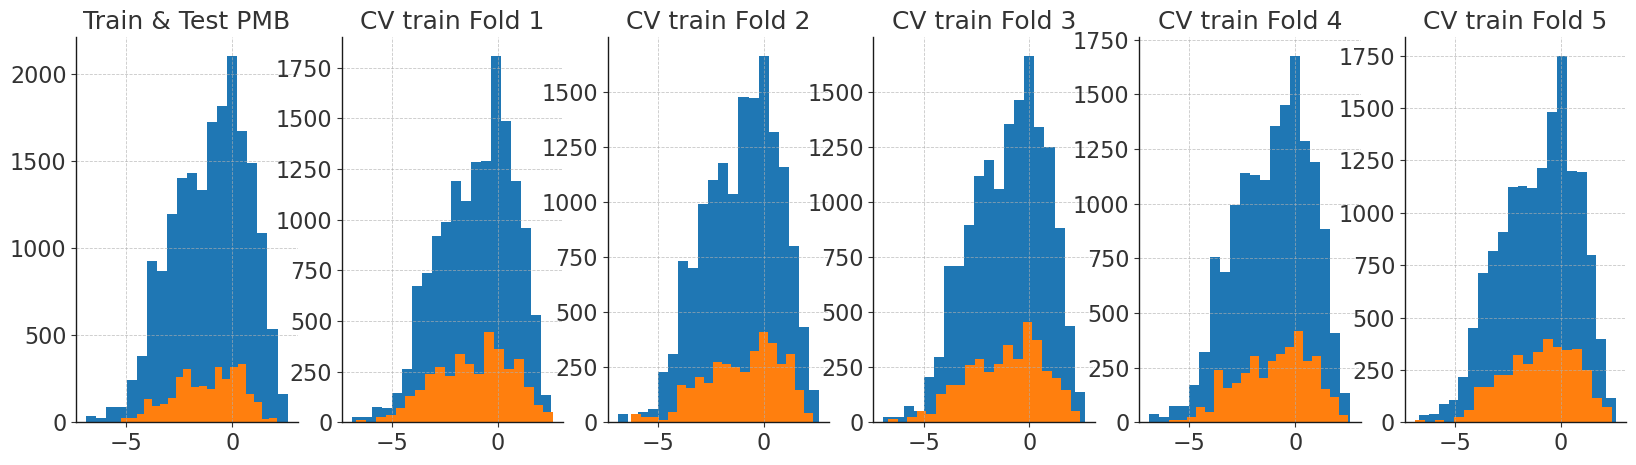

In [15]:
TYPE_SPLIT = 'year'

if TYPE_SPLIT == 'year':
    # Split into training and test years with train_test_split
    train_years, test_years = train_test_split(dataset.data.YEAR.unique(),
                                               test_size=0.2,
                                               random_state=SEED)

    train_indices = dataset.data[dataset.data.YEAR.isin(train_years)].index
    test_indices = dataset.data[dataset.data.YEAR.isin(test_years)].index

    dataloader.set_custom_train_test_indices(train_indices, test_indices)

else:
    # Randomly (though does not separate meas ID)
    train_itr, test_itr = dataloader.set_train_test_split(test_size=0.2,
                                                          shuffle=True)

    train_indices, test_indices = list(train_itr), list(test_itr)

# Get the features and targets of the training data for the indices as defined above, that will be used during the cross validation.
df_X_train = dataset.data.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get test set
df_X_test = dataset.data.iloc[test_indices]
y_test = df_X_test['POINT_BALANCE'].values

# Create the CV splits based on the training dataset. The default value for the number of splits is 5.
splits = dataloader.get_cv_split(n_splits=5, type_fold='group-meas-id')
test_meas_id = df_X_test['ID'].unique()

# Years in training and test set
train_years = df_X_train.YEAR.unique()
test_years = df_X_test.YEAR.unique()
print('Train years:', train_years)
print('Test years:', test_years)

# Plot splits
visualiseSplits(y_test, y_train, splits)

In [16]:
%%time
# Grid search
# For each of the XGBoost parameter, define the grid range
parameters = {
    'max_depth': [
        3,
        4,
        5,
        6,
    ],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300],
    'gamma': [0, 1]
}

feature_columns = [
    'ALTITUDE_CLIMATE', 'ELEVATION_DIFFERENCE', 'aspect', 'fal', 'slhf',
    'slope', 'sshf', 'ssrd', 'str', 't2m', 'tp'
]

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = SEED

# Create a CustomXGBoostRegressor instance
custom_xgboost = mbm.models.CustomXGBoostRegressor(
    meta_data_columns=meta_data_columns, **param_init)
custom_xgboost.randomsearch(
    parameters=parameters,
    n_iter=20,
    splits=splits,
    features=df_X_train,
    targets=y_train,
    num_jobs=-1,
    random_seed=SEED,
)

# save best model
custom_xgboost.save_model('xgb_gries.pkl')

best_params = params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)
/home/vmarijn/mambaforge/envs/MassBalanceMachine/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [13:05:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "meta_data_columns" } are not used.

  warnings.warn(smsg, UserWarning)


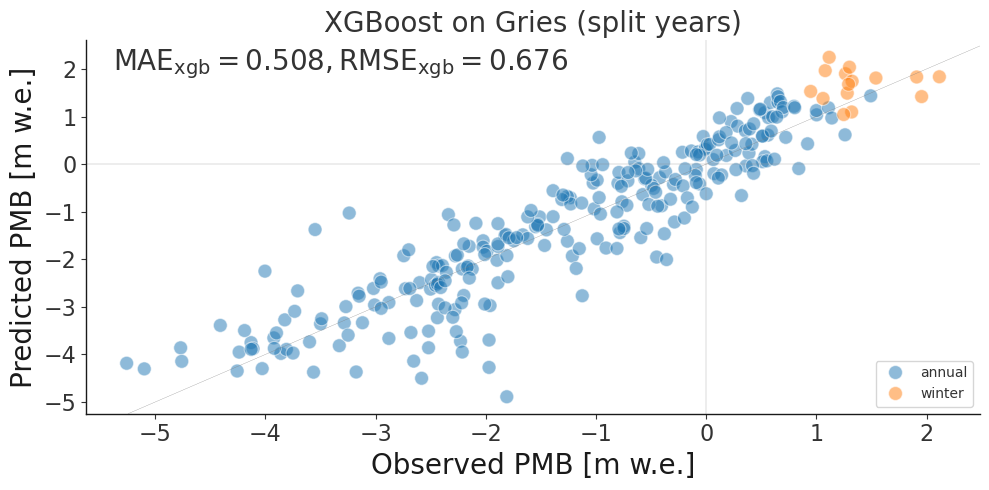

In [ ]:
# Set to CPU for predictions:
xgb = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = xgb._create_features_metadata(
    df_X_test, meta_data_columns)
y_pred = xgb.predict(features_test)

# Make predictions aggr to meas ID:
y_pred_agg = xgb.aggrPredict(metadata_test, meta_data_columns, features_test)

# Calculate scores
score = xgb.score(df_X_test, y_test)  # negative
mse, rmse, mae = xgb.evalMetrics(metadata_test, y_pred, y_test)

# Aggregate predictions to annual or winter:
df_pred = df_X_test.copy()
df_pred['target'] = y_test
grouped_ids = df_pred.groupby('ID').agg({'target': 'mean'})
grouped_ids['pred'] = y_pred_agg
grouped_ids['PERIOD'] = df_X_test.groupby('ID')['PERIOD'].first()

predVSTruth(grouped_ids, mae, rmse, title='XGBoost on Gries (split years)')


(array([  12.,   35.,   43.,   77.,  150.,  217.,  278.,  489., 1441.,
         538.]),
 array([-1.89020944, -1.65639055, -1.42257178, -1.18875289, -0.954934  ,
        -0.72111517, -0.48729631, -0.25347745, -0.01965861,  0.21416023,
         0.44797909]),
 <BarContainer object of 10 artists>)

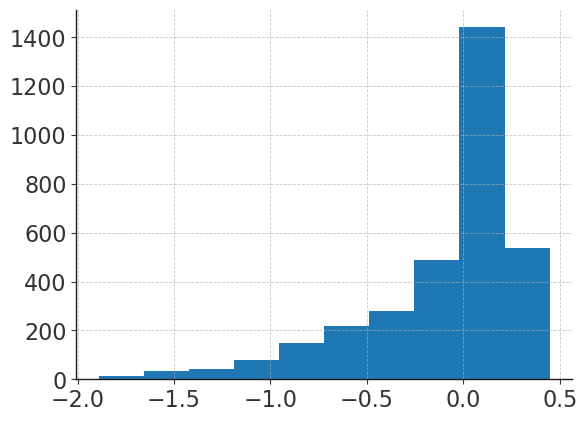

In [ ]:
plt.hist(y_pred)

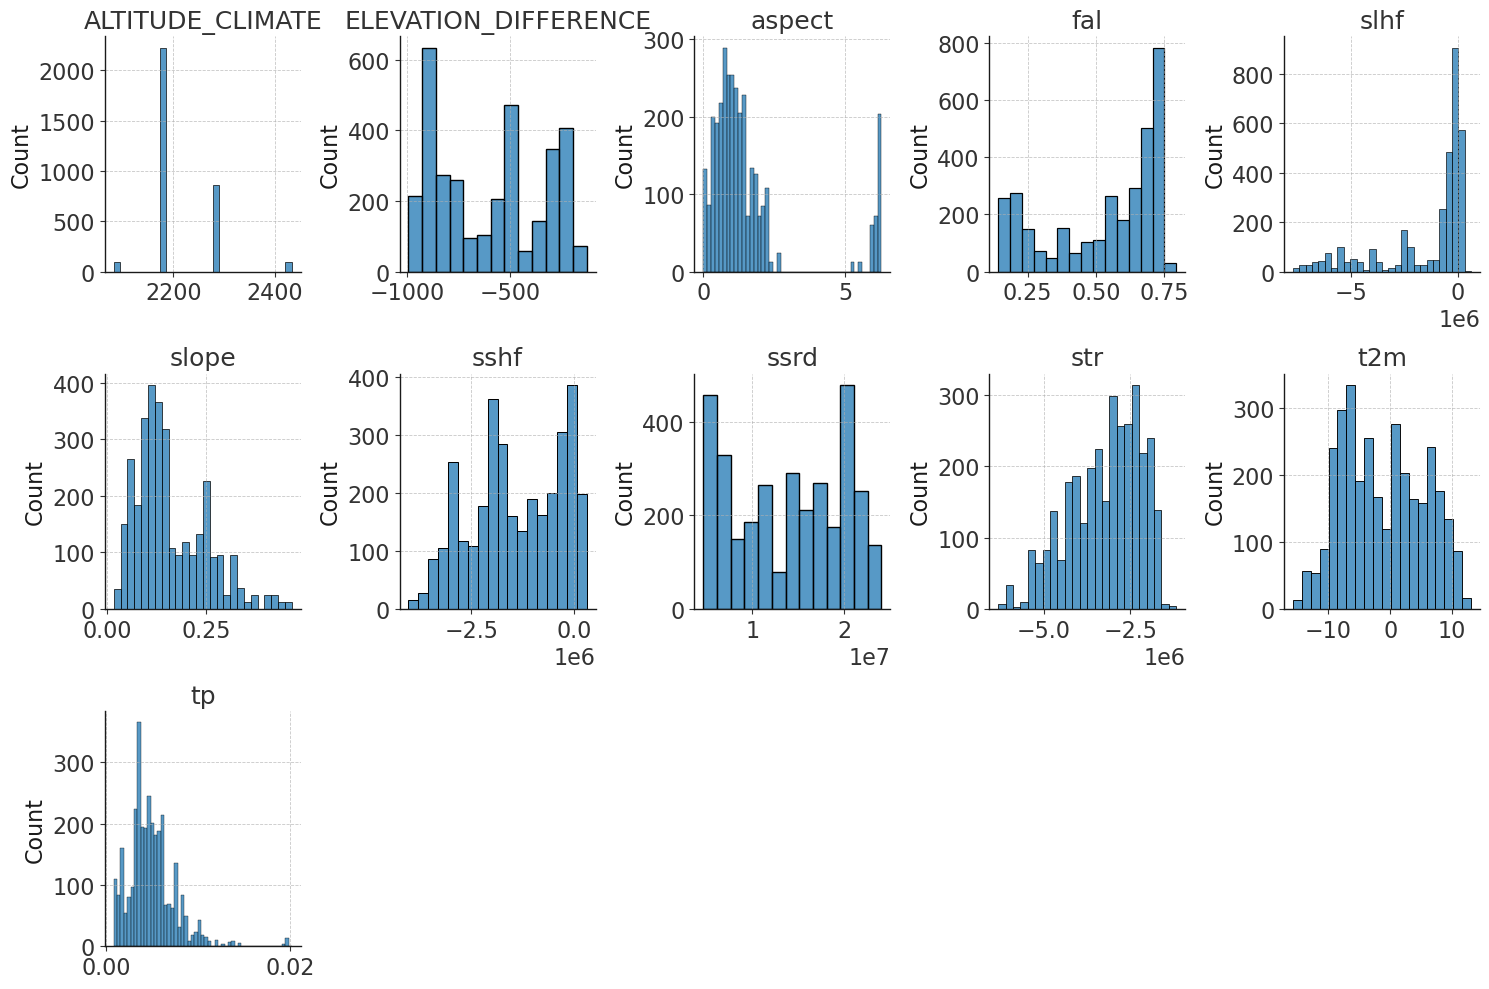

In [ ]:
# Plot distribution of input variables:
fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(feature_columns):
    ax = plt.subplot(3, 5, i + 1)
    sns.histplot(df_X_test[feature], ax=ax)
    ax.set_title(feature)
    ax.set_xlabel('')
plt.tight_layout()